In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from ast import literal_eval
from typing import List
import re
import importlib

import context
os.chdir(context.proj_dir)

import cont_gen.utils
importlib.reload(cont_gen.utils)
import cont_gen.evaluate.cal_metrics
importlib.reload(cont_gen.evaluate.cal_metrics)
from cont_gen.utils import load_jsonl, save_jsonl, plot_multiple_loss, get_loss_df_norm,get_ckpt_paths, load_json
from cont_gen.evaluate.cal_metrics import cal_collective_point_metrics, get_point_counts, get_doc_metrics, get_overall_metrics
import cont_gen.evaluate.io
importlib.reload(cont_gen.evaluate.io)
from cont_gen.evaluate.io import RunManager

In [3]:
# test_data_id = load_jsonl('data/ood_split/seed42_tr29/pmt_01/test_data_id.jsonl')
# test_data_ood = load_jsonl('data/ood_split/seed42_tr29/pmt_01/test_data_ood.jsonl')
cvt = {'answers': lambda k: ' '.join(literal_eval(k))}

tkn_name = 'llama3'
test_meta_id = pd.read_csv(f'data/ood_split/seed42_tr29/{tkn_name}/test_meta_id.csv', converters = cvt)
test_meta_ood = pd.read_csv(f'data/ood_split/seed42_tr29/{tkn_name}/test_meta_ood.csv', converters = cvt)

print(test_meta_ood.columns)
print(test_meta_ood.iloc[0].answers)

Index(['title', 'para_idx', 'q_id', 'answers', 'type'], dtype='object')
SUPPLY CONTRACT


In [2]:
def parse_pred(text: str):
    if text == 'No' or text == 'No.':
        return ''
    else:
        return text.removeprefix('Yes.')

In [5]:
# This is an example
# run_dir = Path('runs/ood/flan-t5-large/seed42_tr29/pmt_01_lr1e-4_bs16_wd0.0')
run_dir = Path('runs/ood/llama3_chat/seed42_tr29/pmt_01_all_lr1e-5_bs16_wd0.0')
# run_dir = Path('runs/ood/mistral/seed42_tr29/pmt_01_yes_no_all_lr1e-5_bs16_wd0.0')
ckpt_dirs = get_ckpt_paths(run_dir)

pred_path = ckpt_dirs[0] / f'predictions_ood_sampled.jsonl'
pred_df = pd.DataFrame(load_jsonl(pred_path))
pred_df['prediction'] = pred_df['prediction'].apply(parse_pred)

ov_mets, detail_df = get_overall_metrics(test_meta_ood, pred_df, lambda k: k)
print(ov_mets)

{'micro_p': 0.7168080911973944, 'micro_r': 0.42199011000100917, 'micro_f1': 0.531237097030332, 'micro_iou': 0.3616901652106219, 'macro_p': 0.7037794396038771, 'macro_r': 0.39631690337499276, 'macro_f1': 0.45701486835517274, 'macro_iou': 0.3240877077152918, 'doc_macro_p': 0.911560334170774, 'doc_macro_r': 0.8334296775519253, 'doc_macro_f1': 0.801285832707837, 'doc_macro_iou': 0.7834904096006842}


In [6]:
detail_df

,q_id,macro_p,macro_r,macro_f1,macro_iou,doc_macro_p,doc_macro_r,doc_macro_f1,doc_macro_iou
0,0,0.385263,0.516949,0.441496,0.283282,0.675885,0.531182,0.429570,0.401444
1,1,0.336603,0.282844,0.307391,0.181608,0.666812,0.386982,0.290121,0.214509
2,5,0.913462,0.316140,0.469716,0.306947,0.974963,0.875835,0.881652,0.870350
3,6,0.464020,0.463445,0.463732,0.301856,0.901961,0.925966,0.855976,0.847535
4,7,0.961353,0.804484,0.875950,0.779281,0.985924,0.864924,0.875654,0.851210
5,8,1.000000,0.000000,0.000000,0.000000,1.000000,0.970588,0.970588,0.970588
6,14,0.945498,0.566761,0.708703,0.548831,0.995269,0.963938,0.967635,0.962598
7,15,0.605744,0.528073,0.564248,0.392998,0.896965,0.885742,0.797997,0.787937
8,17,0.752448,0.159360,0.263016,0.151421,0.962550,0.796807,0.795429,0.784138
9,27,0.949675,0.336207,0.496604,0.330322,0.997770,0.961713,0.970386,0.961474


## Run Manage

In [5]:
# Print runs to cal metric and to infer
top_dir = Path('runs/ood')
run_man = RunManager(top_dir, is_ood = True)

print(run_man.get_runs_to_cal_met())
runs_to_infer = [k for k in run_man.get_runs_to_infer() if 'bos' not in k]
print(runs_to_infer)

set()
['runs/ood/mistral_chat/seed42_tr29/pmt_01_all_lr1e-5_bs16_wd0.0', 'runs/ood/mistral_chat/seed89_tr29/pmt_01_all_lr1e-5_bs16_wd0.0', 'runs/ood/mistral_chat/seed128_tr29/pmt_01_all_lr1e-5_bs16_wd0.0']


In [6]:
# Print runs to cal metric and to infer for ID
run_man_id = RunManager(top_dir, is_ood = False)

print(run_man_id.get_runs_to_cal_met())
runs_to_infer_id = [k for k in run_man_id.get_runs_to_infer() if 'bos' not in k]
print(runs_to_infer_id)

set()
['runs/ood/mistral_chat/seed42_tr29/pmt_01_all_lr1e-5_bs16_wd0.0', 'runs/ood/mistral_chat/seed89_tr29/pmt_01_all_lr1e-5_bs16_wd0.0', 'runs/ood/mistral_chat/seed128_tr29/pmt_01_all_lr1e-5_bs16_wd0.0']


In [23]:
pred_df = pd.DataFrame(load_jsonl('runs/ood/llama3_bos/seed89_tr29/pmt_01_all_lr1e-5_bs16_wd0.0/checkpoint-16484/predictions_ood_all.jsonl'))
test_meta_ood = pd.read_csv(f'data/ood_split/seed42_tr29/llama3/test_meta_ood.csv', converters = cvt)
print(len(test_meta_ood))
print(len(pred_df))
gr_rec = set(map(tuple, pred_df[pred_df['type'] > 0][['title', 'para_idx', 'q_id']].values.tolist()))
pr_rec = set(map(tuple, pred_df[['title', 'para_idx', 'q_id']].values.tolist()))

miss = [k for k in gr_rec if k not in pr_rec]
print(len(miss))

67188
67188
0


In [73]:
run_man.scan_top()

run_man.ckpt_details[run_man.ckpt_details['run_path'] == 'runs/ood/llama3/seed42_tr29/pmt_01_all_lr1e-5_bs16_wd0.0']

,run_path,ckpt,pred_all,pred_sampled,metric_all,metric_sampled
110,runs/ood/llama3/seed42_tr29/pmt_01_all_lr1e-5_...,checkpoint-15692,None,runs/ood/llama3/seed42_tr29/pmt_01_all_lr1e-5_...,None,runs/ood/llama3/seed42_tr29/pmt_01_all_lr1e-5_...
111,runs/ood/llama3/seed42_tr29/pmt_01_all_lr1e-5_...,checkpoint-31384,None,runs/ood/llama3/seed42_tr29/pmt_01_all_lr1e-5_...,None,runs/ood/llama3/seed42_tr29/pmt_01_all_lr1e-5_...
112,runs/ood/llama3/seed42_tr29/pmt_01_all_lr1e-5_...,checkpoint-47076,None,runs/ood/llama3/seed42_tr29/pmt_01_all_lr1e-5_...,None,runs/ood/llama3/seed42_tr29/pmt_01_all_lr1e-5_...
113,runs/ood/llama3/seed42_tr29/pmt_01_all_lr1e-5_...,checkpoint-62768,None,runs/ood/llama3/seed42_tr29/pmt_01_all_lr1e-5_...,None,runs/ood/llama3/seed42_tr29/pmt_01_all_lr1e-5_...
114,runs/ood/llama3/seed42_tr29/pmt_01_all_lr1e-5_...,checkpoint-78460,None,runs/ood/llama3/seed42_tr29/pmt_01_all_lr1e-5_...,None,runs/ood/llama3/seed42_tr29/pmt_01_all_lr1e-5_...


### Calculate Metrics

In [7]:
dist = 'id'
if dist == 'ood':
    cur_man = run_man
else:
    cur_man = run_man_id
cur_man.scan_top()
run_paths = cur_man.get_runs_to_cal_met()
print(len(run_paths))
for run_path in run_paths:
    # if 'phi' in run_path:
    #     continue
    print(f'Handle run {run_path}')
    tk_names = ['llama3', 'mistral', 'phi2', 'flan-t5']
    try:
        tk_name = [k for k in tk_names if k in run_path][0]
    except:
        print(f'missing tk_name for {run_path}')
        continue
    split = Path(run_path).parts[-2]
    test_meta_ood = pd.read_csv(f'data/ood_split/{split}/{tk_name}/test_meta_{dist}.csv', converters = cvt)
    cur_man.cal_metrics_for_run(run_path, test_meta_ood, parse_pred)

0


In [13]:
# print metrics for one run
run_path = 'runs/ood/mistral/seed42_tr29/pmt_01_all_lr1e-5_bs16_wd0.0'
rep_met = 'macro_iou'
ood_steps, ood_mets = run_man.get_run_metrics(run_path, part = 'sampled')
id_steps, id_mets = run_man_id.get_run_metrics(run_path, part = 'sampled')
print(f'{len(ood_steps)}, {len(id_steps)}')
if (ood_steps or id_steps):
    if len(id_steps) > 0:
        # find ckpt with best id
        max_i = np.argmax(id_mets[rep_met].to_list())
        best_step_id = id_steps[max_i]

        ood_i = ood_steps.index(best_step_id)
        print('Best epoch: ', ood_i)
        run_mets = ood_mets.iloc[ood_i].to_dict()
    else:
        best_i = np.argmax(ood_mets[rep_met].to_list())
        print('Best epoch: ', best_i)
        run_mets = ood_mets.iloc[best_i].to_dict()
    keys = [f'{a}_{b}' for a in ['macro', 'micro'] for b in ['p', 'r', 'f1', 'iou']]
    values = [run_mets[k] for k in keys]
    v_str = [f'{k*100:.2f}' for k in values]
    print(keys)
    print('\t'.join(v_str))

5, 5
Best epoch:  4
['macro_p', 'macro_r', 'macro_f1', 'macro_iou', 'micro_p', 'micro_r', 'micro_f1', 'micro_iou']
54.47	57.94	50.62	38.07	49.24	59.38	53.84	36.83


In [9]:
run_man.runs

,model,split,run_name,has_pred,has_metric
0,mistral,seed42_tr29,pmt_01_yes_no_all_lr1e-5_bs16_wd0.0,1,1
1,mistral,seed42_tr29,pmt_01_all_lr1e-5_bs16_wd0.0,1,1
2,mistral_chat,seed42_tr29,pmt_01_all_lr1e-5_bs16_wd0.0,0,0
3,mistral_chat,seed89_tr29,pmt_01_all_lr1e-5_bs16_wd0.0,0,0
4,mistral_chat,seed128_tr29,pmt_01_all_lr1e-5_bs16_wd0.0,0,0
5,llama3_chat,seed42_tr29,pmt_01_all_lr1e-5_bs16_wd0.0,1,1
6,llama3,seed42_tr29,pmt_01_yes_no_all_lr1e-5_bs16_wd0.0,1,1
7,llama3,seed42_tr29,pmt_01_all_lr1e-5_bs16_wd0.0,1,1


### Visualize

In [29]:
import matplotlib.pyplot as plt

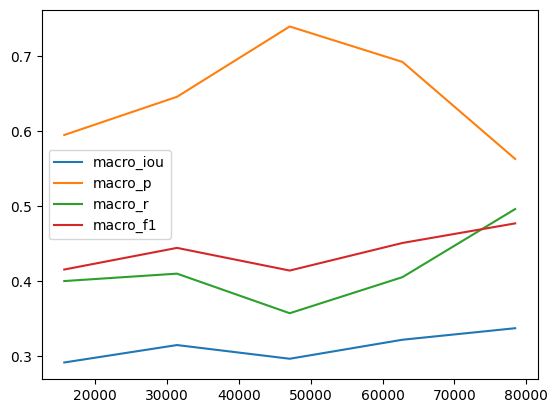

In [30]:
steps, mets = run_man_id.get_run_metrics('runs/ood/llama3/seed42_tr29/pmt_01_all_lr1e-5_bs16_wd0.0')

for mn in ['macro_iou', 'macro_p', 'macro_r', 'macro_f1']:
# for mn in ['micro_iou', 'micro_p', 'micro_r']:
    plt.plot(steps, mets[mn], label = mn)
plt.legend()

In [31]:
mets

,doc_macro_f1,doc_macro_iou,doc_macro_p,doc_macro_r,macro_f1,macro_iou,macro_p,macro_r,micro_f1,micro_iou,micro_p,micro_r
0,0.823106,0.809600,0.922408,0.862671,0.415770,0.291860,0.595086,0.400382,0.461046,0.299584,0.637018,0.361253
1,0.838035,0.823903,0.928694,0.869648,0.444602,0.315088,0.645989,0.410266,0.491539,0.325854,0.679149,0.385145
2,0.845451,0.834670,0.967197,0.851819,0.414388,0.296826,0.739717,0.357507,0.463038,0.301269,0.805566,0.324893
3,0.849832,0.836703,0.943058,0.870423,0.451160,0.322174,0.692472,0.405592,0.505018,0.337809,0.745111,0.381946
4,0.842676,0.826418,0.901468,0.896577,0.477249,0.337523,0.563148,0.496372,0.541670,0.371432,0.602652,0.491896


In [32]:
run_dir = Path('runs/ood/flan-t5-large/seed42_tr29/pmt_01_lr1e-4_bs16_wd0.0')
ckpt_dirs = get_ckpt_paths(run_dir)
ckpt_dir = ckpt_dirs[-1]
# get detail results
save_path = ckpt_dir / f'detail_metrics_ood_sampled.csv'
met_df_ood = pd.read_csv(save_path)
iou_mat_ood = met_df_ood['micro_iou']

save_path = ckpt_dir / f'detail_metrics_id_sampled.csv'
met_df_id = pd.read_csv(save_path)
iou_mat_id = met_df_id['micro_iou']

IndexError: list index out of range

In [ ]:
all_info = pd.read_csv('data/clause/all_info.csv')
q2name = {i: row['clause_type'] for i,row in all_info.iterrows()}

In [ ]:
def plot_clause_bar(met_df):
    x_labels = met_df['q_id'].apply(lambda k: q2name[k]).to_list()
    y = met_df['micro_iou'].to_list()
    ax = plt.gca()
    # fig, ax = plt.subplots()
    ax.barh(range(len(y)), y)
    ax.set_yticks(range(len(y)))
    ax.set_yticklabels(x_labels)

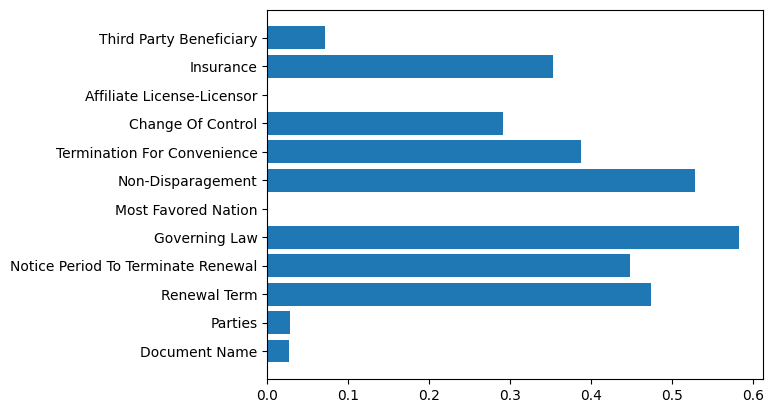

In [ ]:
plot_clause_bar(met_df_ood)

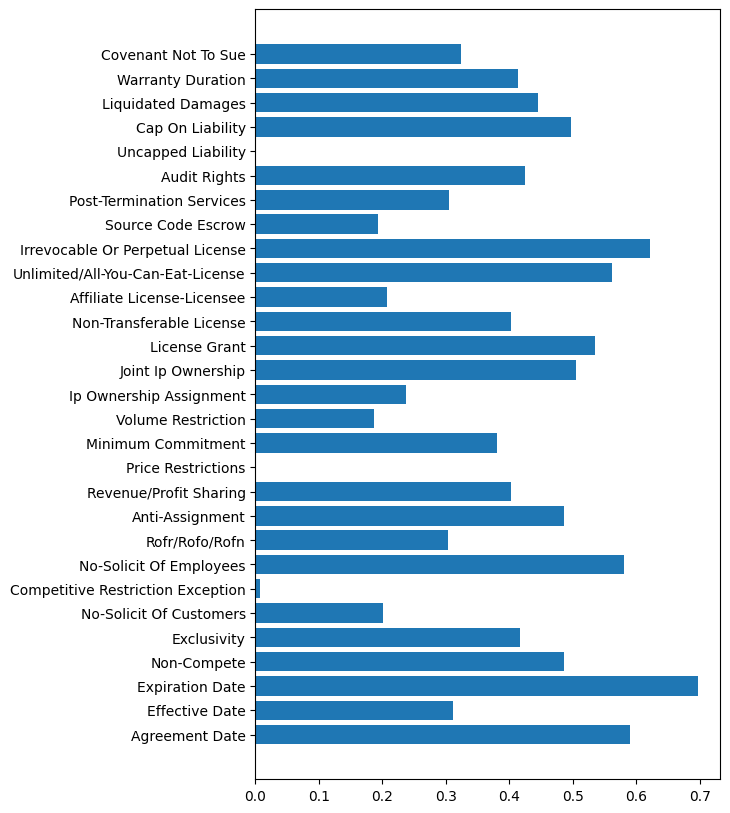

In [ ]:
plt.figure(figsize = (6,10))
plot_clause_bar(met_df_id)

In [67]:
met_df_ood['q_id'].apply(lambda k: q2name[k])

0                          Document Name
1                                Parties
2                           Renewal Term
3     Notice Period To Terminate Renewal
4                          Governing Law
5                    Most Favored Nation
6                      Non-Disparagement
7            Termination For Convenience
8                      Change Of Control
9             Affiliate License-Licensor
10                             Insurance
11               Third Party Beneficiary
Name: q_id, dtype: object

### Loss Plot

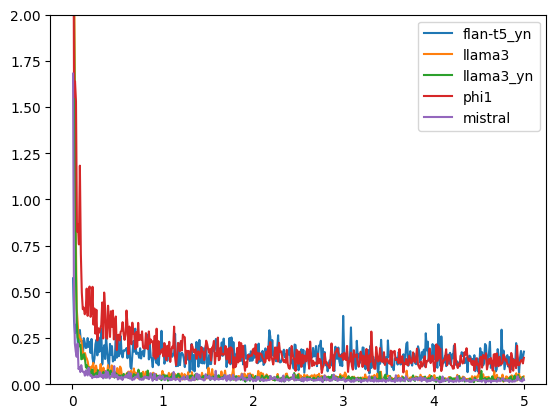

In [33]:
loss_dt = {
    # 'flan-t5': get_loss_df_norm('runs/ood/flan-t5-large/seed42_tr29/pmt_01_lr1e-4_bs16_wd0.0'),
    'flan-t5_yn': get_loss_df_norm('runs/ood/flan-t5-large/seed42_tr29/pmt_01_yes_no_lr1e-4_bs16_wd0.0'),
    'llama3': get_loss_df_norm('runs/ood/llama3/seed42_tr29/pmt_01_all_lr1e-5_bs16_wd0.0'),
    # 'llama3_kv': get_loss_df_norm('runs/ood/llama3/seed42_tr29/pmt_01_lr1e-5_bs16_wd0.0'),
    'llama3_yn': get_loss_df_norm('runs/ood/llama3/seed42_tr29/pmt_01_yes_no_all_lr1e-5_bs16_wd0.0'),
    # 'llama3_ynkv': get_loss_df_norm('runs/ood/llama3/seed42_tr29/pmt_01_yes_no_lr1e-5_bs16_wd0.0'),
    'phi1': get_loss_df_norm('runs/ood/phi-1_5/seed42_tr29/pmt_01_lr1e-5_bs16_wd0.0'),
    'mistral': get_loss_df_norm('runs/ood/mistral/seed42_tr29/pmt_01_all_lr1e-5_bs16_wd0.0'),
    # 'mistral_yn': get_loss_df_norm('runs/ood/mistral/seed42_tr29/pmt_01_yes_no_all_lr1e-5_bs16_wd0.0'),
}

plot_multiple_loss(loss_dt, y_lim = 2)

In [28]:
x = pd.DataFrame({'a': [1,1,2,3], 'b': [1,2,3,4], 'c': [5,6,7,8]})
r = x.groupby('a').apply(lambda k: k.mean())
# r = x.groupby(['a', 'b']).apply(lambda k: pd.Series([k['a'].mean(), k['b'].mean()], index = ['am', 'bm']))
print(type(r))
print(r)

<class 'pandas.core.frame.DataFrame'>
     a    b    c
a               
1  1.0  1.5  5.5
2  2.0  3.0  7.0
3  3.0  4.0  8.0


In [23]:
r2 = r.reset_index()
print(r2)

   a  b   am   bm
0  1  1  1.0  1.0
1  1  2  1.0  2.0
2  2  3  2.0  3.0
3  3  4  3.0  4.0


In [30]:
r['a'].to_dict()

{1: 1.0, 2: 2.0, 3: 3.0}